In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import missingno as msno
import seaborn as sns
import tensorflow as tf
import os as os
import h5py

**Comments:** In this unit, we will use Keras to manage images and create the three sets. We will load all images with this function. We use an image generator with augmentations, such as horizontal flips and rotation range, to introduce more diversity into the training set. As we already have a separate validation dataset, we do not include any validation split in the generator.

# Preparing the data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator with augmentation such as horizontal flip and rotation range to bring more diversity to the train set
train_generator = ImageDataGenerator(rescale= 1 / 255, horizontal_flip=True, rotation_range=5)

# Create the validation generator 
val_generator = ImageDataGenerator(rescale= 1/ 255)

# Create the test generator
test_generator = ImageDataGenerator(rescale= 1/ 255)

In [3]:
!tree /A cifar10

Structure du dossier pour le volume OS
Le numéro de série du volume est A405-9E50
C:\USERS\SAULAIS\ONEDRIVE - OCP SA\BUREAU\EPFL\ADSML_COURS_4\COURSE PROJECT\CIFAR10
Chemin d’accès non valide - \USERS\SAULAIS\ONEDRIVE - OCP SA\BUREAU\EPFL\ADSML_COURS_4\COURSE PROJECT\CIFAR10
Aucun sous-dossier existant 



In [4]:
# Folder list
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

**Comments:** We do not shuffle data for the validation nor test set. In addition, we do not include subset as we have a separate set of data. We keep the default parameter. We keep the original picture size as target size. 

In [5]:
import os

# Train set 
trainset = train_generator.flow_from_directory(
    os.path.join("train"), 
    classes=folder_list,       
    batch_size=32, # We select 32 as a batch size
    class_mode="sparse",
    shuffle=True,
    target_size=(224, 224),
)

# validation and test sets
valset = val_generator.flow_from_directory(
    os.path.join("valid"), 
    classes=folder_list, 
    batch_size=32,
    class_mode="sparse",
    target_size=(224, 224),
    shuffle=False
)

testset = test_generator.flow_from_directory(
    os.path.join("test"),  
    classes=folder_list,     
    batch_size=32,
    target_size=(224, 224),
    shuffle=False
)


Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


In [6]:
# Extract labels for train, validation, and test sets
train_labels = trainset.classes
val_labels = valset.classes
test_labels = testset.classes
train_labels.shape, val_labels.shape, test_labels.shape

((280,), (139,), (52,))

In [7]:
import h5py
import numpy as np

def save_h5(iterator, output_path):

    images, labels = [], []
    
    # Loop through the iterator to extract all data
    for batch_images, batch_labels in iterator:
        images.append(batch_images)
        labels.append(batch_labels)
        if len(images) * iterator.batch_size >= iterator.n:
            break

    # Combine batches into single arrays
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Save to an HDF5 file
    with h5py.File(output_path, "w") as h5_file:
        h5_file.create_dataset("features", data=images)
        h5_file.create_dataset("labels", data=labels)

    print(f"Saved to {output_path}: Features Shape {images.shape}, Labels Shape {labels.shape}")


In [8]:
# Run the function to train, validation, and test sets to separate .h5 files
save_h5(trainset, "train_data_no_hlf.h5")
save_h5(valset, "val_data_no_hlf.h5")
save_h5(testset, "test_data_no_hlf.h5")

Saved to train_data_no_hlf.h5: Features Shape (280, 224, 224, 3), Labels Shape (280,)
Saved to val_data_no_hlf.h5: Features Shape (139, 224, 224, 3), Labels Shape (139,)
Saved to test_data_no_hlf.h5: Features Shape (52, 224, 224, 3), Labels Shape (52, 6)


In [9]:
# Checking the structure of folders
!tree /A train

Structure du dossier pour le volume OS
Le numéro de série du volume est A405-9E50
C:\USERS\SAULAIS\ONEDRIVE - OCP SA\BUREAU\EPFL\ADSML_COURS_4\COURSE PROJECT\TRAIN
+---.ipynb_checkpoints
+---bike
+---car
+---motorcycle
+---other
+---truck
\---van


In [10]:
# Checking if the sets intersets
set(trainset.filenames).intersection(set(valset.filenames)), set(trainset.filenames).intersection(set(testset.filenames))

(set(), set())

In [11]:
batch_imgs, batch_labels = trainset.next()

print("Batch images:", batch_imgs.shape)
print("Batch labels:", batch_labels.shape)

Batch images: (32, 224, 224, 3)
Batch labels: (32,)


In [12]:
trainset.class_indices
testset.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

*Comments:* The sets do not intersect. Each batch of images has 32 image with an RGB format in 224x224. There are 6 classes in each folder

In [13]:
# Create the image feature extractor
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/2"

In [14]:
feature_extractor = hub.load(model_url)

In [15]:
import tensorflow_hub as hub
import tensorflow as tf

# URL for MobileNetV2 feature extractor on TensorFlow Hub
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Load the pretrained feature extractor
feature_extractor = hub.KerasLayer(model_url, input_shape=(224, 224, 3))

In [16]:
train_hlf = []
train_labels = []
test_hlf = []
test_labels = []
val_hlf = []
val_labels = []

for _ in range(len(trainset)):  # Number of batches in the dataset
    batch_imgs, batch_labels = trainset.next()
    batch_features = feature_extractor(batch_imgs)  # Extract features
    train_hlf.append(batch_features.numpy())
    train_labels.append(batch_labels)
for _ in range(len(testset)):  # Number of batches in the dataset
    batch_imgs, batch_labels = testset.next()
    batch_features = feature_extractor(batch_imgs)  # Extract features
    test_hlf.append(batch_features.numpy())
    test_labels.append(batch_labels)

for _ in range(len(valset)):  # Number of batches in the dataset
    batch_imgs, batch_labels = valset.next()
    batch_features = feature_extractor(batch_imgs)  # Extract features
    val_hlf.append(batch_features.numpy())
    val_labels.append(batch_labels)   

    
# Convert to numpy arrays
train_hlf = np.concatenate(train_hlf, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Convert to numpy arrays
test_hlf = np.concatenate(test_hlf, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Convert to numpy arrays
val_hlf = np.concatenate(val_hlf, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

print("train features shape:", train_hlf.shape)
print("train labels shape:", train_labels.shape)
print("train features shape:", val_hlf.shape)
print("train labels shape:", val_labels.shape)

train features shape: (280, 1280)
train labels shape: (280,)
train features shape: (139, 1280)
train labels shape: (139,)


# Model 1 : 1 layer  

In [18]:
import tensorflow.keras as keras
# Creation of the model
model = keras.Sequential()
# Adding 1 layer in the model
model.add(keras.layers.Dense(units=6, input_dim=1280, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 7686      
Total params: 7,686
Trainable params: 7,686
Non-trainable params: 0
_________________________________________________________________


**Comments:** This 1 layer model includes the 1280 dimensions corresponding to the high level features and the 6 classes. The number of parameters calculated is 7686. We use the softmax activation function as the model is multi classes. We are now compiling the model with a cross entropy loss function and Adam optimizer. We will measure the accuracy to evaluate the model. 

In [19]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

In [20]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)

In [21]:
# Train model
history = model.fit(train_hlf, train_labels, validation_data=(val_hlf, val_labels), epochs=50, callbacks=[early_stopping])

Epoch 1/50
9/9 [==============================] - 1s 62ms/step - loss: 1.3959 - acc: 0.4607 - val_loss: 0.9195 - val_acc: 0.7122
Epoch 2/50
9/9 [==============================] - 0s 14ms/step - loss: 0.6760 - acc: 0.8036 - val_loss: 0.5494 - val_acc: 0.8705
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 0.3745 - acc: 0.9036 - val_loss: 0.4020 - val_acc: 0.8633
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.2581 - acc: 0.9429 - val_loss: 0.3593 - val_acc: 0.8849
Epoch 5/50
9/9 [==============================] - 0s 22ms/step - loss: 0.2004 - acc: 0.9536 - val_loss: 0.3358 - val_acc: 0.8993
Epoch 6/50
9/9 [==============================] - 0s 14ms/step - loss: 0.1612 - acc: 0.9571 - val_loss: 0.3163 - val_acc: 0.8849
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1387 - acc: 0.9714 - val_loss: 0.3034 - val_acc: 0.8849
Epoch 8/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1186 - acc: 0.9821 - val_l

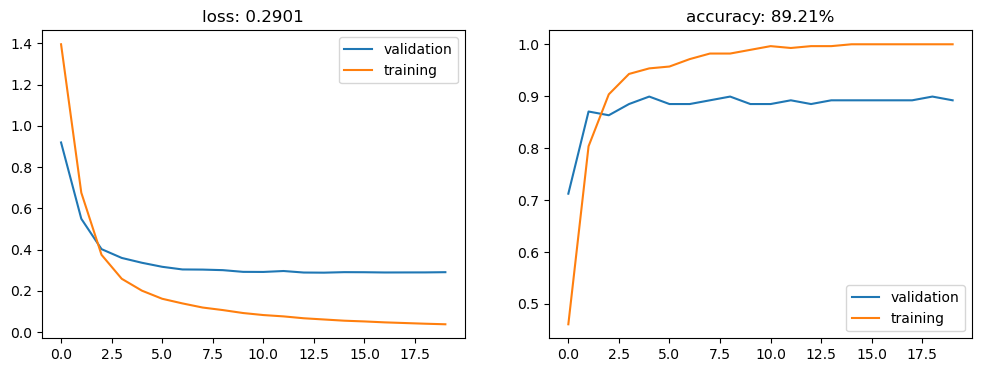

In [22]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history.history["val_acc"][-1] * 100))
ax2.plot(history.history["val_acc"], label="validation")
ax2.plot(history.history["acc"], label="training")
ax2.legend()

plt.show()

In [23]:
test_preds = model.predict(test_hlf)
print("Predictions:", test_preds.shape)

Predictions: (52, 6)


In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes,            # array with true labels
    y_pred=test_preds.argmax(axis=1),  # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = "Predictions"
matrix_df.index.name = "True class"
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,12,0,0,0,0,0
car,0,11,0,0,0,0
motorcycle,0,0,9,0,0,0
other,0,0,0,8,0,0
truck,0,0,0,2,5,0
van,0,1,0,0,1,3


# As test data are one hot encoded, we have to convert them back into numbers from 0 to 5

In [38]:
# Convert one-hot encoded labels
test_labels_converted = np.argmax(test_labels, axis=1)


In [51]:
# Calculate the accuracy of the model 
(test_loss, nn_score) = model.evaluate(test_hlf, test_labels_converted, batch_size=32)
nn_score_1 = nn_score * 100
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(nn_score_1))

2/2 [==============================] - 0s 5ms/step - loss: 0.2467 - acc: 0.9231
Test loss: 0.25
Test accuracy: 92.31%


In [58]:
#Save the score in the SQL Table 
import sqlite3

layer_1_data = {'model': ['1-layer-nn'],
        'test_accuracy': [nn_score_1]}
layer_1_df = pd.DataFrame(layer_1_data)

# Save to SQLite
conn = sqlite3.connect('results.db')
layer_1_df.to_sql('results_table', conn, if_exists='append', index=False)
conn.close()

*Comment:* This first model is already good with 90% of accuracy. Based on the test set, the model made 1 error classifying a van as a car. 

# Model 2 : 2 Layers

*Comment:* We are now adding a new layer with Relu activation function 

In [25]:
# Creation of the model
model_2 = keras.Sequential()
# Adding 1 layer in the model with activation function relu
model_2.add(keras.layers.Dense(units=128, input_dim=1280, activation="relu")),

model_2.add(keras.layers.Dense(units=6, activation="softmax")),

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 7686      
Total params: 7,686
Trainable params: 7,686
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile the model
model_2.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

In [27]:

history_2 = model_2.fit(train_hlf, train_labels, validation_data=(val_hlf, val_labels), epochs=50, callbacks=early_stopping)

Epoch 1/50
9/9 [==============================] - 2s 50ms/step - loss: 0.9772 - acc: 0.6571 - val_loss: 0.4131 - val_acc: 0.8705
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 0.2131 - acc: 0.9321 - val_loss: 0.3102 - val_acc: 0.8993
Epoch 3/50
9/9 [==============================] - 0s 16ms/step - loss: 0.1005 - acc: 0.9643 - val_loss: 0.2934 - val_acc: 0.9137
Epoch 4/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0515 - acc: 0.9893 - val_loss: 0.3302 - val_acc: 0.8993
Epoch 5/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.3166 - val_acc: 0.9065
Epoch 6/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.3222 - val_acc: 0.9137
Epoch 7/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.3302 - val_acc: 0.8993
Epoch 8/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0104 - acc: 1.0000 - val

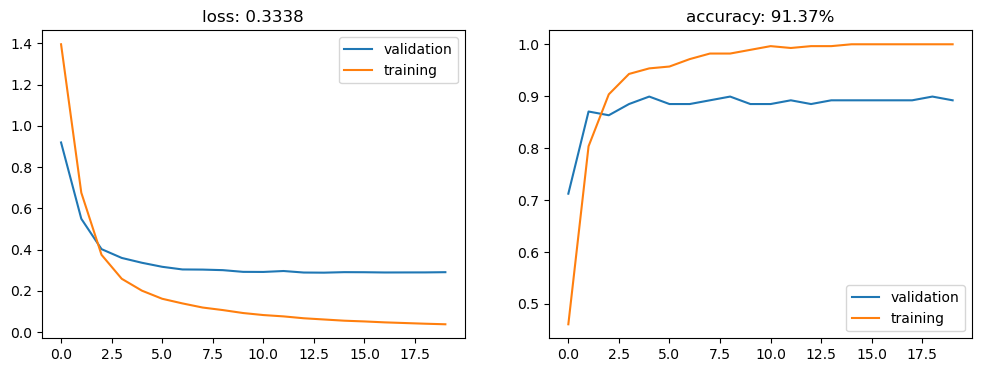

In [28]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history_2.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history_2.history["val_acc"][-1] * 100))
ax2.plot(history.history["val_acc"], label="validation")
ax2.plot(history.history["acc"], label="training")
ax2.legend()

plt.show()

In [29]:
test_preds_2 = model_2.predict(test_hlf)
print("Predictions:", test_preds_2.shape)

Predictions: (52, 6)


In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes,            # array with true labels
    y_pred=test_preds_2.argmax(axis=1),  # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = "Predictions"
matrix_df.index.name = "True class"
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,12,0,0,0,0,0
car,0,11,0,0,0,0
motorcycle,0,0,9,0,0,0
other,0,0,0,8,0,0
truck,0,0,0,0,7,0
van,0,1,0,0,1,3


**Comments:** We managed toimprove the accuracy of the model slightly in adding an additional layer. This model made only 1 mistake classifying a van as a car. We can say that adding a second layer doesn't improve the performance of the model. It is likely due to the fact that we are using high level features.

In [53]:
# Calculate the accuracy of the model 
(test_loss, nn_2_score) = model_2.evaluate(test_hlf, test_labels_converted, batch_size=32)
nn_score_2 = nn_2_score * 100
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * nn_score_2))

2/2 [==============================] - 0s 5ms/step - loss: 0.1900 - acc: 0.9615
Test loss: 0.19
Test accuracy: 9615.38%


In [57]:
#Save the score in the SQL Table 
import sqlite3

layer_2_data = {'model': ['2-layer-nn'],
        'test_accuracy': [nn_score_2]}
layer_2_df = pd.DataFrame(layer_2_data)

# Save to SQLite
conn = sqlite3.connect('results.db')
layer_2_df.to_sql('results_table', conn, if_exists='append', index=False)
conn.close()